In [27]:
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice

import math
import sklearn as sk
import xgboost as xgb
import statsmodels.tsa.stattools as sm_tools
import statsmodels.tsa.arima_model as stats_arima

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from finance.utilities import utils, financial_utils, time_series_utils

## Stocks

In [8]:
query = """
    select
        e.symbol
        , e.market_datetime
        , e.open
        , e.high
        , e.low
        , e.close
        , e.volume
        , f.high_52
        , f.low_52
        , f.dividend_amount
        , f.pe_ratio
        , f.quick_ratio
        , f.current_ratio
    from td.equities_view as e
    left join td.fundamentals as f 
        on f.symbol = e.symbol
    where e.symbol = 'BA'
    order by e.market_datetime
    """

df = utils.query_db(db_connection=utils.DW_STOCKS_JUPYTER, query=query)
df.head()

,symbol,market_datetime,open,high,low,close,volume,high_52,low_52,dividend_amount,pe_ratio,quick_ratio,current_ratio
0,BA,1999-09-20 05:00:00,43.6250,43.6250,42.7500,42.8750,2683500.0,None,None,None,None,None,None
1,BA,1999-09-21 05:00:00,42.8750,43.1250,42.5625,42.7500,2523000.0,None,None,None,None,None,None
2,BA,1999-09-22 05:00:00,42.8750,43.9375,42.8750,43.5000,2453900.0,None,None,None,None,None,None
3,BA,1999-09-23 05:00:00,43.5000,43.5000,42.5625,42.7500,2721300.0,None,None,None,None,None,None
4,BA,1999-09-24 05:00:00,42.5625,42.5625,41.0625,42.0625,3349900.0,None,None,None,None,None,None


### Time series

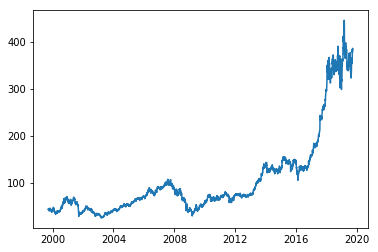

In [9]:
plt.plot(df['market_datetime'], df['open'])
plt.show()

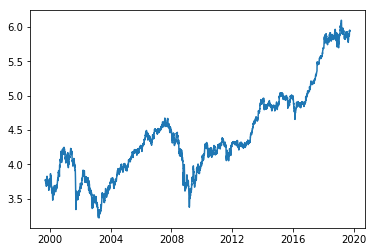

In [10]:
plt.plot(df['market_datetime'], np.log(df['open']))
plt.show()

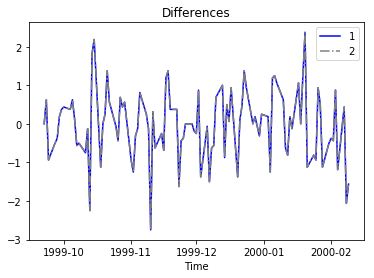

In [11]:
time_series_utils.ARIMA(series=df['open'].head(100), datetimes=df['market_datetime'].head(100)).differences_plot()

/home/nautilus/anaconda3/envs/babylon/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/nautilus/anaconda3/envs/babylon/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/nautilus/anaconda3/envs/babylon/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` ins

/home/nautilus/anaconda3/envs/babylon/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/nautilus/anaconda3/envs/babylon/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/nautilus/anaconda3/envs/babylon/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` ins

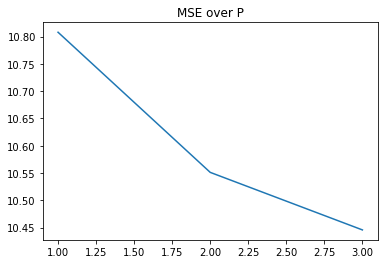

In [12]:
time_series_utils.ARIMA(series=df['open'],
          datetimes=df['market_datetime'], p=(1,4), d=(0,1), q=(0,1),
          forecast_date=('2019-08-05', '2019-08-09')).benchmark_plot()

### Time series metrics

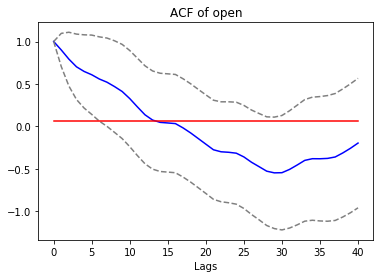

In [13]:
time_series_utils.ARIMA(series=df['open']).acf_plot()

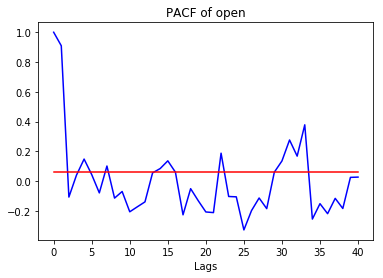

In [18]:
time_series_utils.ARIMA(series=df['open']).pacf_plot()

### ARIMA 

In [19]:
time_series_utils.ARIMA(series=df['open'], 
                        datetimes=df['market_datetime'], 
                        forecast_date='2019-08-08').model_forecast

{'forecast': 328.9389308939831,
 'aic': 23927.333538773386,
 'bic': 23953.549181870792}

In [20]:
time_series_utils.ARIMA(series=df['open'],
                        datetimes=df['market_datetime'],
                        p=3, d=2, forecast_date='2019-09-02').optimal_params

TypeError: 'Timestamp' object does not support indexing

### K neighbors

In [21]:
full = df.tail(1000)
train = full.head(900)
test = df.tail(100)

In [22]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(train['open'].values.reshape(-1,1))
nbrs.kneighbors(train['open'].values.reshape(-1,1))

(array([[0.  , 0.04],
        [0.  , 0.04],
        [0.  , 0.04],
        ...,
        [0.  , 0.05],
        [0.  , 0.06],
        [0.  , 1.01]]), array([[  0, 196],
        [  1, 165],
        [  2, 236],
        ...,
        [897, 760],
        [898, 866],
        [899, 898]]))

### K means

In [23]:
cluster = KMeans(n_clusters=10, random_state=0).fit(train['open'].values.reshape(-1,1))
preds = cluster.predict(test['open'].values.reshape(-1,1))
cluster.cluster_centers_

array([[236.8425641 ],
       [354.90910714],
       [151.3370264 ],
       [186.10585138],
       [375.94219697],
       [334.65497027],
       [129.6651448 ],
       [261.70982759],
       [302.19828571],
       [418.77791667]])

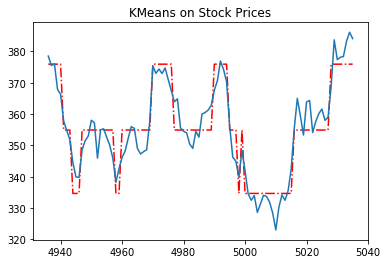

In [24]:
# Need to show how this looks when actually iter across days
plt.figure()
plt.title('KMeans on Stock Prices')
plt.plot(test.index.values, cluster.cluster_centers_[preds], color='r', linestyle='-.')
plt.plot(test['open'])
plt.show()

### Random forest

In [41]:
train = df[['market_datetime', 'open', 'volume']]
train['market_datetime'] = train['market_datetime'].astype(int)
train = xgb.DMatrix(train)